--- 
# Sandbox (Faune)
Tests for each part of this project

---

### TODOs and notes 

- add what max wrote to the report 
- one part results : present the scores and logistic regression 
- 2nd part : present the ear then log reg then the trading signal with irf
- conclusion 

### Imports

In [50]:
#external libraries
import polars as pl
from datetime import date
import nest_asyncio
import os

#internal libraries
from prompts import process_in_batches, import_data, preprocess_responses
from utils import compute_sentiment_ear, local_projection_irf_polars, get_logistic_regression, get_btc_returns, irf_signal_strategy
import matplotlib.pyplot as plt
import seaborn as sns

## Tests for EAR and IRF with scores

In [51]:
scores = pl.read_csv('scores_2.csv')

In [52]:
scores.head()

date,increase,decrease,diff,score
str,i64,i64,i64,f64
"""2017-09-29""",1,0,1,1.0
"""2017-10-31""",0,0,0,NaN
"""2017-11-12""",1,0,1,1.0
"""2017-11-13""",0,0,0,NaN
"""2017-11-14""",1,0,1,1.0


In [53]:
sentiment = scores.select('score').to_series().fill_nan(None).fill_null(strategy='forward') #change later ?

In [54]:
ear = compute_sentiment_ear(sentiment=sentiment)

In [55]:
scores = scores.with_columns(ear)

In [56]:
scores

date,increase,decrease,diff,score,sentiment_ear
str,i64,i64,i64,f64,f64
"""2017-09-29""",1,0,1,1.0,NaN
"""2017-10-31""",0,0,0,NaN,0.476233
"""2017-11-12""",1,0,1,1.0,0.476233
"""2017-11-13""",0,0,0,NaN,0.476233
"""2017-11-14""",1,0,1,1.0,0.476233
…,…,…,…,…,…
"""2025-01-03""",0,0,0,NaN,-0.048399
"""2025-01-04""",0,0,0,NaN,-0.048399
"""2025-01-05""",0,0,0,NaN,-0.048399


Text(0.5, 1.0, 'Sentiment EAR')

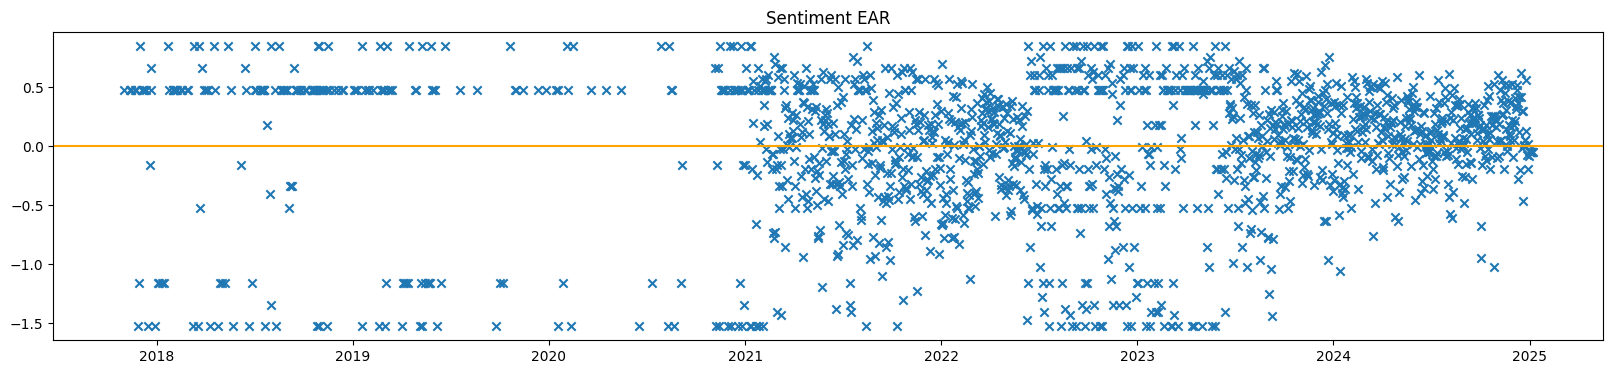

In [57]:
fig = plt.figure(figsize=(20,4)) #redo with good results 
plt.scatter(y = scores.select('sentiment_ear').to_series().to_numpy(), x = scores.select(pl.col('date').str.to_date()).to_series().to_numpy(), marker='x')
plt.axhline(color="orange")
plt.title('Sentiment EAR')

Text(0.5, 1.0, 'Sentiment EAR distribution')

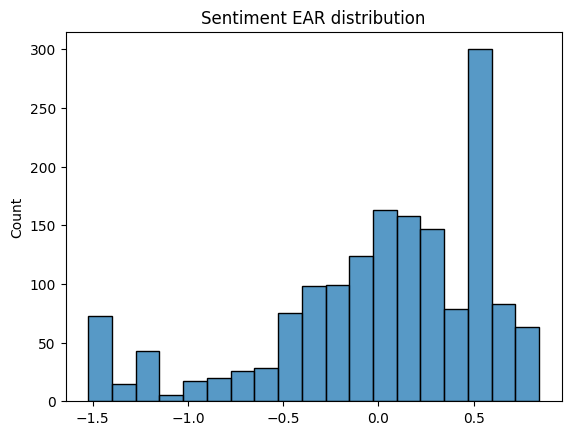

In [59]:
fig = sns.histplot(scores.select('sentiment_ear').to_series().to_numpy())
plt.title('Sentiment EAR distribution')

Text(0.5, 1.0, 'Scores')

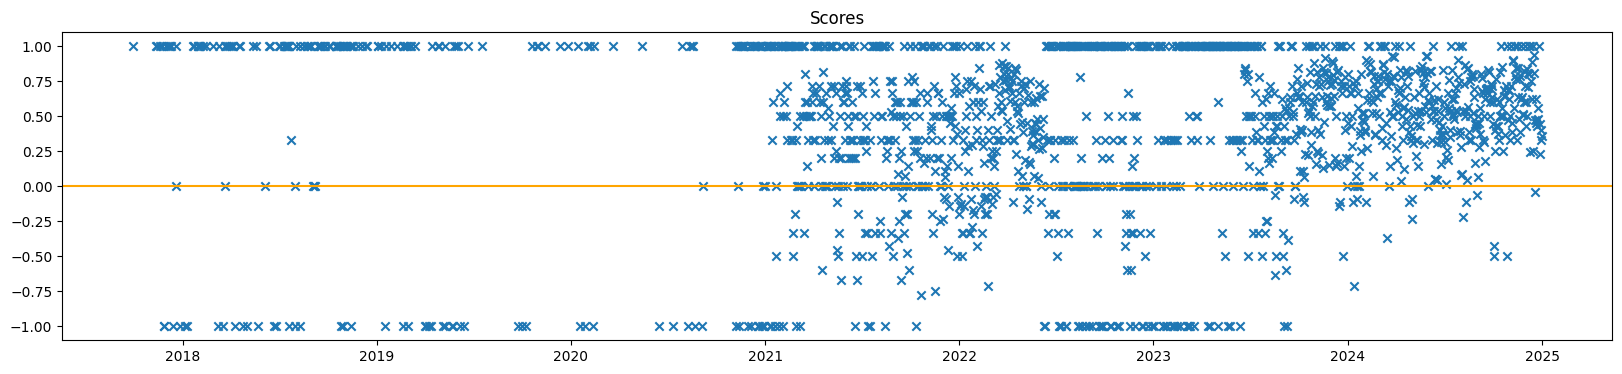

In [60]:
fig = plt.figure(figsize=(20,4)) #redo with good results 
plt.scatter(y = scores.select('score').to_series().to_numpy(), x = scores.select(pl.col('date').str.to_date()).to_series().to_numpy(), marker='x')
plt.axhline(color="orange")
plt.title('Scores')

Text(0.5, 1.0, 'Score distribution')

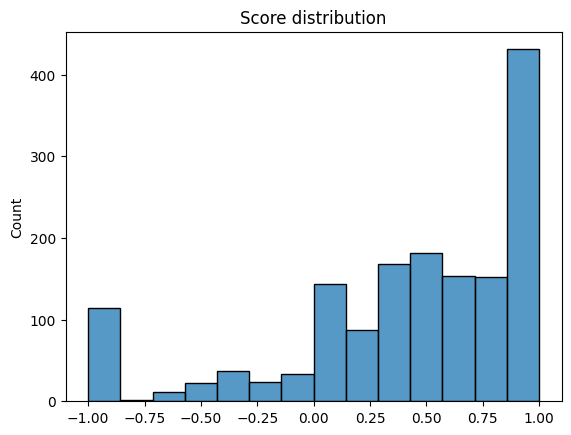

In [61]:
fig = sns.histplot(scores.select('score').to_series().to_numpy())
plt.title('Score distribution')

In [62]:
scores= scores.with_columns(pl.col('date').str.to_date())

In [63]:
returns = get_btc_returns(scores=scores)

In [64]:
returns = returns.join(scores, on='date').drop_nans()

c:\Users\faune\miniconda3\envs\crypto-sentiment\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5480769230769231
Precision: 0.5494431545080328
Recall: 0.5480769230769231
F1 score: 0.5440283400809718
Confusion matrix:
 [[235 283]
 [187 335]]
Accuracy (Out of Sample): 0.5414258188824663
Precision (Out of Sample): 0.5437021677557877
Recall (Out of Sample): 0.5414258188824663
F1 score (Out of Sample): 0.5123376487069347
Confusion matrix (Out of Sample):
 [[ 73 178]
 [ 60 208]]


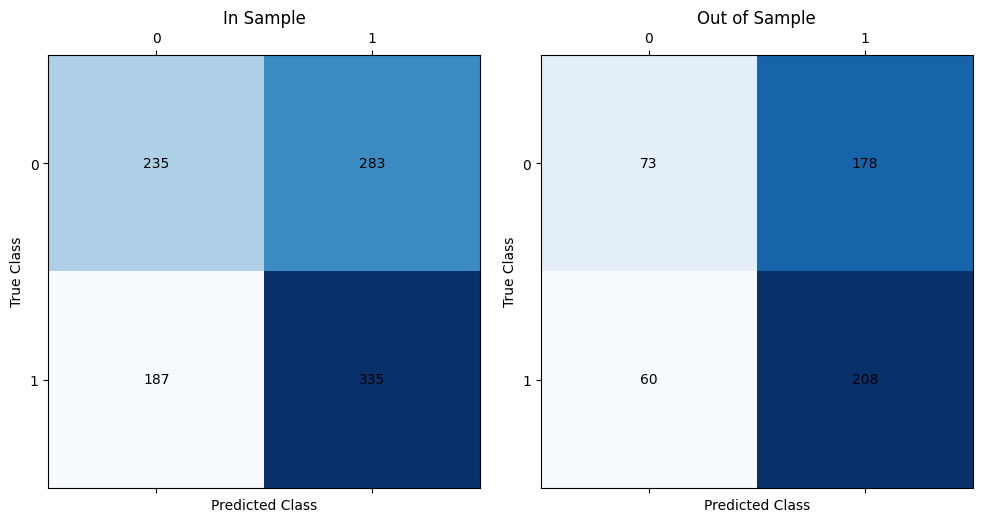

In [65]:
get_logistic_regression(penalty=None, X= returns.select('sentiment_ear').to_series().to_numpy().reshape(-1, 1), y = returns.select('actual').to_series().to_list())

c:\Users\faune\miniconda3\envs\crypto-sentiment\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5269230769230769
Precision: 0.5270256548408488
Recall: 0.5269230769230769
F1 score: 0.5255489093724879
Confusion matrix:
 [[245 273]
 [219 303]]
Accuracy (Out of Sample): 0.5317919075144508
Precision (Out of Sample): 0.5317773159850555
Recall (Out of Sample): 0.5317919075144508
F1 score (Out of Sample): 0.4984420130870762
Confusion matrix (Out of Sample):
 [[ 67 184]
 [ 59 209]]


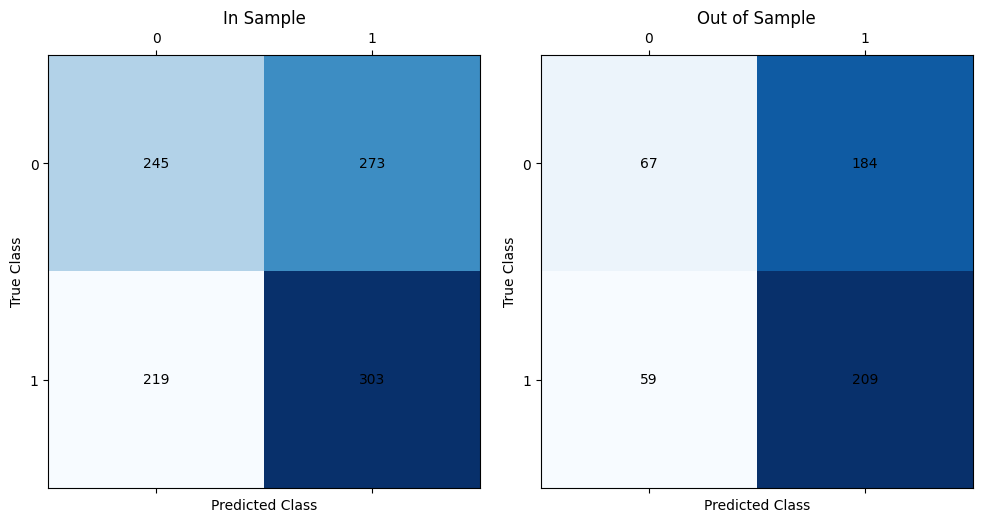

In [66]:
get_logistic_regression( penalty=None, X= returns.select('score').to_series().to_numpy().reshape(-1, 1), y = returns.select('actual').to_series().to_list())

In [67]:
irf = local_projection_irf_polars(y=returns.select('returns'), x=returns.select('sentiment_ear'), control=returns.select('returns')) #fix when we have correct scores

In [68]:
irf_sum = sum(irf.values())

In [69]:
returns

date,close,returns,actual,increase,decrease,diff,score,sentiment_ear
date,f64,f64,i32,i64,i64,i64,f64,f64
2017-11-12,5950.069824,-0.066248,0,1,0,1,1.0,0.476233
2017-11-14,6635.75,0.011559,1,1,0,1,1.0,0.476233
2017-11-20,8200.639648,0.02022,1,1,0,1,1.0,0.476233
2017-11-23,8038.77002,-0.026367,0,1,0,1,1.0,0.476233
2017-11-27,9818.349609,0.050959,1,0,1,-1,-1.0,-1.523767
…,…,…,…,…,…,…,…,…
2024-12-27,94164.859375,-0.017169,0,13,5,8,0.444444,-0.079322
2024-12-28,95163.929688,0.010554,1,8,5,3,0.230769,-0.190828
2024-12-29,93530.226562,-0.017316,0,7,3,4,0.4,0.017699


In [70]:
# Assume sentiment_ear and returns are aligned Polars Series
strategy_returns = irf_signal_strategy(returns.select('sentiment_ear'), irf, returns.select('returns'))

# Plotting or performance stats
df = pl.DataFrame({"strategy": strategy_returns, "returns": returns}).unnest('returns')
df = df.with_columns(
    (1 + pl.col("strategy")).cum_prod().alias("cumulative_strategy"),
    (1 + pl.col("returns")).cum_prod().alias("cumulative_market")
)


Text(0.5, 1.0, 'Trading strategy returns vs BTC returns')

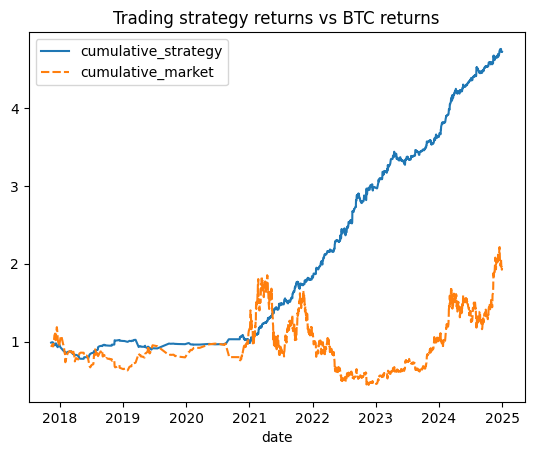

In [71]:
sns.lineplot(df.select('cumulative_strategy', 'cumulative_market', 'date').to_pandas().set_index('date'))
plt.title('Trading strategy returns vs BTC returns')

out of sample

In [140]:
sentiment_ear = returns.select('sentiment_ear')
n = len(sentiment_ear)
train_size = int(n * 0.7)

# In-sample data
y_train = returns.select('returns').slice(0, train_size)
x_train = sentiment_ear.slice(0, train_size)
control_train = returns.select('returns').slice(0, train_size)

# Estimate IRF in-sample
irf = local_projection_irf_polars(
    y=y_train,
    x=x_train,
    control=control_train,
)

irf_sum = sum(irf.values())

# Out-of-sample data
sentiment_test = sentiment_ear.slice(train_size, n - train_size)
returns_test = returns.select('returns').slice(train_size, n - train_size)

# Generate signal: EAR × IRF_sum
signal_test = sentiment_test * irf_sum
position_test = pl.DataFrame(signal_test).with_columns(pl.when(pl.col('sentiment_ear').gt(0)).then(1).otherwise(-1)).to_series()
strategy_returns_test = (position_test * returns_test)

# in-sample data
sentiment_train = sentiment_ear.slice(0,  train_size)
returns_train = returns.select('returns').slice(0, train_size)

# Generate signal: EAR × IRF_sum in sample
signal_train = sentiment_train * irf_sum
position_train = pl.DataFrame(signal_train).with_columns(pl.when(pl.col('sentiment_ear').gt(0)).then(1).otherwise(-1)).to_series()
strategy_returns_train = (position_train * returns_train)



In [142]:
all_strat = pl.concat([strategy_returns_train, strategy_returns_test]).rename({'returns':'strat_returns'})
ret = returns.with_columns(all_strat)

In [143]:
ret

date,close,returns,actual,increase,decrease,diff,score,sentiment_ear,strat_returns
date,f64,f64,i32,i64,i64,i64,f64,f64,f64
2017-11-12,5950.069824,-0.066248,0,1,0,1,1.0,0.476233,-0.003292
2017-11-14,6635.75,0.011559,1,1,0,1,1.0,0.476233,0.000574
2017-11-20,8200.639648,0.02022,1,1,0,1,1.0,0.476233,0.001005
2017-11-23,8038.77002,-0.026367,0,1,0,1,1.0,0.476233,-0.00131
2017-11-27,9818.349609,0.050959,1,0,1,-1,-1.0,-1.523767,-0.008101
…,…,…,…,…,…,…,…,…,…
2024-12-27,94164.859375,-0.017169,0,13,5,8,0.444444,-0.079322,0.000142
2024-12-28,95163.929688,0.010554,1,8,5,3,0.230769,-0.190828,-0.00021
2024-12-29,93530.226562,-0.017316,0,7,3,4,0.4,0.017699,-0.000032


In [149]:
ret.with_columns((pl.col('strat_returns').add(1)).cum_prod(), (pl.col('returns').add(1)).cum_prod()).select('date', 'strat_returns', 'returns').to_pandas().set_index('date')

,strat_returns,returns
date,,
2017-11-12,0.996708,0.933752
2017-11-14,0.997281,0.944545
2017-11-20,0.998283,0.963643
2017-11-23,0.996975,0.938235
2017-11-27,0.988898,0.986046
...,...,...
2024-12-27,1.566201,1.956281
2024-12-28,1.565872,1.976928
2024-12-29,1.565822,1.942694


Text(0.5, 1.0, 'Srategy Returns with out of sample')

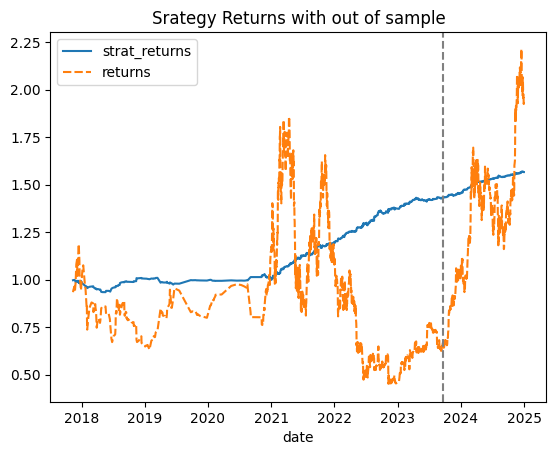

In [153]:
sns.lineplot(ret.with_columns((pl.col('strat_returns').add(1)).cum_prod(), (pl.col('returns').add(1)).cum_prod()).select('date', 'strat_returns', 'returns').to_pandas().set_index('date'))
split_idx = int(len(returns.select('date').to_series().to_list()) * 0.7)
test_dates = returns.select('date').to_series().to_list()[split_idx:]
test_start_date = test_dates[0]
plt.axvline(test_start_date, color="gray", linestyle="--", label="Test Start")
plt.title('Srategy Returns with out of sample')

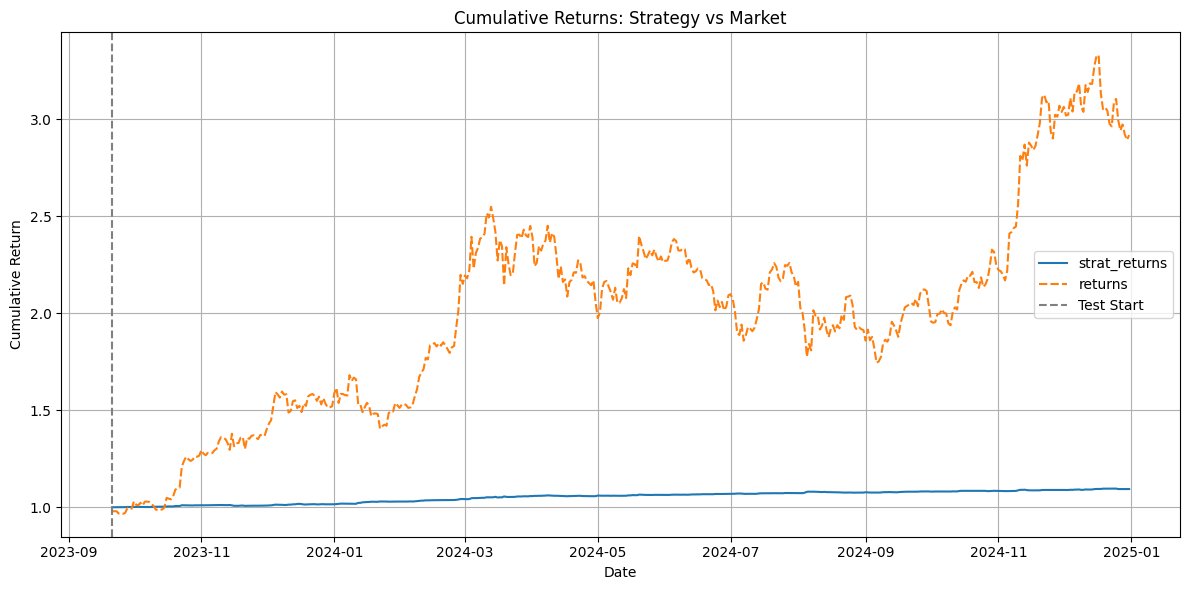

In [116]:
train_ratio = 0.7
import pandas as pd 
full_dates = returns.select('date')
# Convert to Pandas for seaborn
strategy_pd = strategy_returns.to_pandas()
returns_pd = returns_test.to_pandas()

# Get start index of test period
split_idx = int(len(full_dates) * train_ratio)
test_dates = full_dates[split_idx:]

# Create DataFrame with cumulative returns
df_plot = pl.DataFrame({
    "Date": test_dates.to_series(),
    "Cumulative Strategy": (1 + strategy_pd).cumprod(),
    "Cumulative Market": (1 + returns_pd).cumprod()
})

df_plot = df_plot.unnest('Cumulative Strategy').rename({'returns': 'strat_returns'}).unnest('Cumulative Market')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot.to_pandas().set_index('Date'))

# Add vertical line at start of test
test_start_date = test_dates[0].to_pandas()
plt.axvline(test_start_date, color="gray", linestyle="--", label="Test Start")

plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
df_plot

date,strat_returns,returns
datetime[ms],f64,f64
2023-09-21 00:00:00,0.999786,0.97898
2023-09-22 00:00:00,0.999761,0.979419
2023-09-23 00:00:00,0.999761,0.979413
2023-09-24 00:00:00,1.000272,0.967454
2023-09-25 00:00:00,1.000216,0.968988
…,…,…
2024-12-27 00:00:00,1.093749,2.942185
2024-12-28 00:00:00,1.09352,2.973237
2024-12-29 00:00:00,1.093485,2.921751


Text(0.5, 1.0, 'Scores')

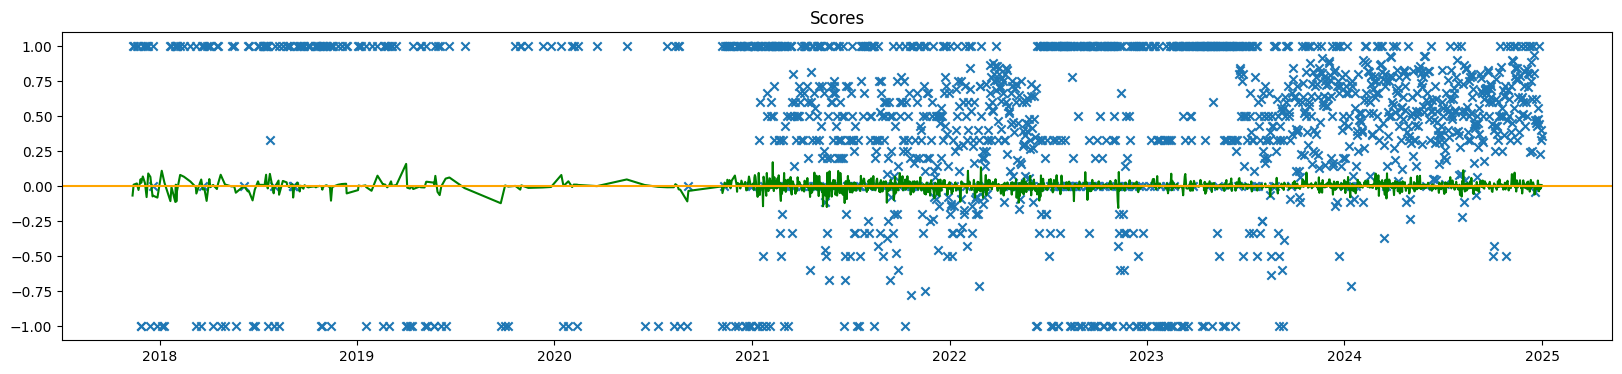

In [75]:
fig = plt.figure(figsize=(20,4)) #redo with good results 
plt.scatter(y = returns.select('score').to_series().to_numpy(), x = returns.select(pl.col('date')).to_series().to_numpy(), marker='x')
plt.plot(returns.select('returns', 'date').to_pandas().set_index('date'), color='green')
plt.axhline(color="orange")
plt.title('Scores')

Text(0.5, 1.0, 'EAR')

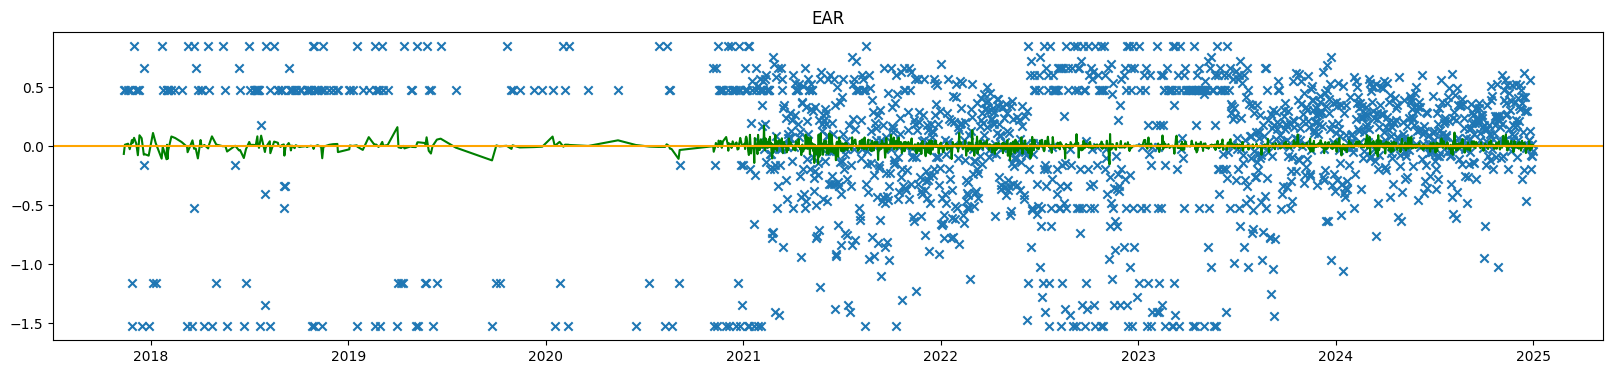

In [77]:
fig = plt.figure(figsize=(20,4)) #redo with good results 
plt.scatter(y = returns.select('sentiment_ear').to_series().to_numpy(), x = returns.select(pl.col('date')).to_series().to_numpy(), marker='x')
plt.plot(returns.select('returns', 'date').to_pandas().set_index('date'), color='green')
plt.axhline(color="orange")
plt.title('EAR')

Text(0.5, 1.0, 'Binarized returns distribution')

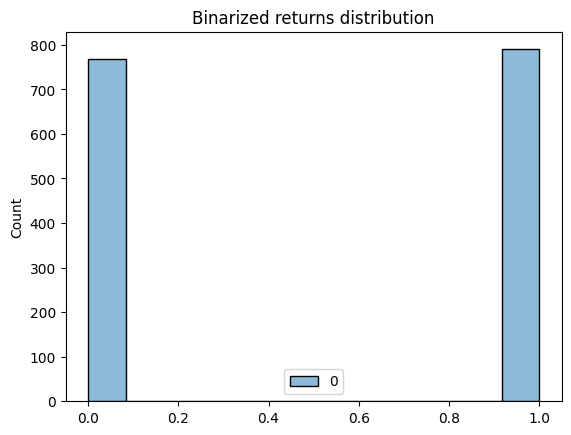

In [81]:
sns.histplot(returns.select('actual'))
plt.title('Binarized returns distribution')

## Importing data test

In [2]:
titles = import_data()

In [17]:
pl.config.Config.set_tbl_width_chars(-1)
titles.drop('prompts').head()

date,title
date,str
2017-09-29,"""Edward Snowden: Zcash Is 'Most Interesting Bitcoin Alternative'"""
2017-10-31,"""Bitcoin Cash: Hard Fork Planned for Better EDA on Nov 13"""
2017-10-31,"""Bitcoin Cash Developers Propose Date for November Hard Fork"""
2017-11-12,"""Confusion and Euphoria As Bitcoin Cash Tops $30 Billion"""
2017-11-13,"""Bitcoin Cash Hard Forks In Bid to Ease Mining Difficulties"""


## Prompting test

### Basic sentences
Adapted from the mistral website

In [3]:
responses = preprocess_responses()

In [5]:
responses.write_csv("scores.csv")

In [ ]:
# nest_asyncio.apply()
# prompts = titles.select('prompts').to_series().to_list()
# csv_path = "responses_2017_2024.csv"
# first_write = not os.path.exists(csv_path)

# async for batch in process_in_batches(prompts, batch_size=200, concurrency=10):
#     batch_df = pl.DataFrame({
#         "index": [r[0] for r in batch],
#         "prompt": [r[1] for r in batch],
#         "response": [r[2] for r in batch],
#     })

#     csv_string = batch_df.write_csv(separator=",", include_header=first_write)
#     with open(csv_path, "a", encoding="utf-8") as f:
#         f.write(csv_string)

#     first_write = False
#     print(f"Wrote {len(batch)} rows to {csv_path}")


Processing prompts 0 to 199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 200 to 399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 400 to 599...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 600 to 799...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 800 to 999...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1000 to 1199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1200 to 1399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1400 to 1599...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1600 to 1799...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1800 to 1999...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2000 to 2199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2200 to 2399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2400 to 2599...
Wrote 200 rows to responses_2017_2024.csv
Processing 